# Flight Delay Analysis Project
#### Analyze flight data to determine the impact of a delayed arriving flight and if there is a correlated departure delay for the same aircraft. 
Research Question: : Is there a correlation between the size of an airport, International versus Regional, and the likelihood that a departing flight would be delayed due to a delayed inbound aircraft? <br>
### Hypothesis:
There is a positive correlation between the size of an airport (International vs. Regional) and the likelihood that a departing flight would be delayed due to a delayed inbound aircraft. Specifically, it is hypothesized that International airports with higher volumes of air traffic will exhibit a higher probability of delayed departures due to late aircraft compared to smaller, Regional airports.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import scipy as sc
import time_functions as tf
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
%matplotlib inline

# Set Pandas display options
pd.options.display.max_columns = None
pd.options.display.max_rows = None

## Import Data
| File                      | Description |
| ------------------------- | ----------- |
| airlines.csv              | Data contains airline name information |
| airports.csv              | Data contains airport information |
| flights.csv               | Data contains all flight data for 2015 |
| international_airports.csv | Data identifies U.S. International Airports |
| bts_codes.csv | Cross-reference data to get IATA Code from Airport ID |

In [2]:
# Load csv files into Pandas DataFrames
df_airlines = pd.read_csv("data/airlines.csv", index_col=False)
df_airports = pd.read_csv("data/airports.csv", index_col=False)
df_flights = pd.read_csv("data/flights.csv", index_col=False, low_memory=False)
df_intl = pd.read_csv("data/international_airports.csv", index_col=False)
df_bts = pd.read_csv("data/bts_codes.csv", index_col=False)

## Assessing Data
Visualize sample data from each of the imported datasets to determine which values will be of interest for the analysis.

In [3]:
# View the first 5 rows of the Airlines dataset
df_airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [4]:
# View the first 5 rows of the Airport dataset
df_airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [5]:
# View the first 5 rows of the Flights dataset
df_flights.head()


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205.0,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280.0,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285.0,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235.0,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Find total rows and columns in flights data
df_flights.shape

(5819079, 31)

In [7]:
# View the first 5 rows of the International dataset
df_intl.head()

,CITY,AIRPORT_NAME,STATE,IATA-Code,Status
0,Atlanta,Hartsfield-Jackson Atlanta International,Georgia,ATL,INTL
1,Anchorage,Ted Stevens Anchorage International Airport,Alaska,ANC,INTL
2,Austin,Austin-Bergstrom International,Texas,AUS,INTL
3,Baltimore,Baltimore/Washington International - BWI Airport,Maryland,BWI,INTL
4,Boston,Logan International Airport,Massachusetts,BOS,INTL


In [8]:
# View the first 5 rows of the BTS dataset
df_bts.head()

,AIRPORT_SEQ_ID,AIRPORT_ID,AIRPORT,DISPLAY_AIRPORT_NAME,DISPLAY_AIRPORT_CITY_NAME_FULL
0,1000101,10001,01A,Afognak Lake Airport,"Afognak Lake, AK"
1,1000301,10003,03A,Bear Creek Mining Strip,"Granite Mountain, AK"
2,1000401,10004,04A,Lik Mining Camp,"Lik, AK"
3,1000501,10005,05A,Little Squaw Airport,"Little Squaw, AK"
4,1000601,10006,06A,Kizhuyak Bay,"Kizhuyak, AK"


## Data Cleaning
Review the Flights data and determine which columns and rows can be removed from the dataset.

In [9]:
# Get listing of all columns in the Flight data
df_flights.columns

Index(['YEAR', 'MONTH', 'DAY', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER',
       'TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
       'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME',
       'ARRIVAL_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype='object')

Drop columns that are not needed in the analysis:
- FLIGHT_NUMBER, DAY_OF_WEEK, AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY, CANCELLATION_REASON, TAXI_OUT,
       WHEELS_OFF, SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, DISTANCE, WHEELS_ON, TAXI_IN

In [10]:
# Drop columns 
drop = ['FLIGHT_NUMBER', 'DAY_OF_WEEK', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY', 'CANCELLATION_REASON', 'TAXI_OUT',
       'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME', 'AIR_TIME', 'DISTANCE',
       'WHEELS_ON', 'TAXI_IN']

df_flights.drop(drop, axis=1, inplace=True)

There are flights that were DIVERTED or CANCELLED. For the purposes of the analysis, those rows will be removed. Drop the columns when finished.

In [11]:
# Drop rows where the flight was CANCELLED OR DIVERTED
df_flights.drop(df_flights.index[df_flights['CANCELLED'] == 1], inplace=True)
df_flights.drop(df_flights.index[df_flights['DIVERTED'] == 1], inplace=True)

# Drop CANCELLED & DIVERTED columns
df_flights.drop('CANCELLED', axis=1, inplace=True)
df_flights.drop('DIVERTED', axis=1, inplace=True)

All NaN values have been removed from the dataset.

In [12]:
# Examine the Flights dataset for NaN (Null) values 
df_flights.isnull().sum(), df_flights.shape

(YEAR                   0
 MONTH                  0
 DAY                    0
 AIRLINE                0
 TAIL_NUMBER            0
 ORIGIN_AIRPORT         0
 DESTINATION_AIRPORT    0
 SCHEDULED_DEPARTURE    0
 DEPARTURE_TIME         0
 DEPARTURE_DELAY        0
 SCHEDULED_ARRIVAL      0
 ARRIVAL_TIME           0
 ARRIVAL_DELAY          0
 dtype: int64,
 (5714008, 13))

The Flights data started with 5819079 rows of data. We now have 5714008 rows remaining.<br>
The total reduction of 1.8% in data rows should not have any material impact on our final results.

Convert DEPARTURE_DELAY and ARRIVAL_DELAY from Float to Integer values.

In [13]:
# Convert column values from Float to Integer
df_flights = df_flights.astype({'DEPARTURE_DELAY':int})
df_flights = df_flights.astype({'ARRIVAL_DELAY':int})

In [14]:
df_flights.head()

,YEAR,MONTH,DAY,AIRLINE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY
0,2015,1,1,AS,N407AS,ANC,SEA,5,2354.0,-11,430,408.0,-22
1,2015,1,1,AA,N3KUAA,LAX,PBI,10,2.0,-8,750,741.0,-9
2,2015,1,1,US,N171US,SFO,CLT,20,18.0,-2,806,811.0,5
3,2015,1,1,AA,N3HYAA,LAX,MIA,20,15.0,-5,805,756.0,-9
4,2015,1,1,AS,N527AS,SEA,ANC,25,24.0,-1,320,259.0,-21


## Join Datasets
- Rename column AIRLINE to AIRLINE_CODE in df_flights
- From df_airports bring in the Airport Name based on the IATA code of the ORIGIN_AIRPORT in df_flights
- From df_airlines bring in the Airline Name based on the IATA code of the AIRLINE_CODE in df_flights
- From df_international_airports bring in the airport Status based on the IATA code of the ORIGIN_AIRPORT in df_flights

In [15]:
# Rename column
df_flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

In df_flights there are standard Airport IATA codes, plus numeric AIRPORT ID codes. Before we match to the values in df_airports to add the airport names, we need to convert the numeric AIRPORT ID codes into IATA Codes. Create temp df's and map values between df_flights and df_bts.

In [16]:
# Filter out ORIGIN_AIRPORT and DESTINATION_AIRPORT with more than 3 characters

# Convert AIRPORT_ID to string type
df_bts['AIRPORT_ID'] = df_bts['AIRPORT_ID'].astype(str)

# Filter out ORIGIN_AIRPORT and DESTINATION_AIRPORT with more than 3 characters
df_org = df_flights['ORIGIN_AIRPORT'].str.len() > 3
df_dest = df_flights['DESTINATION_AIRPORT'].str.len() > 3

# Create a DataFrame with unique mappings
df_org_map = df_bts.groupby('AIRPORT_ID').first()['AIRPORT']
df_dest_map = df_bts.groupby('AIRPORT_ID').first()['AIRPORT']

# Map codes to IATA codes only when there's a match
df_flights.loc[df_org, 'ORIGIN_AIRPORT'] = df_flights.loc[df_org, 'ORIGIN_AIRPORT'].map(df_org_map).fillna(df_flights.loc[df_org, 'ORIGIN_AIRPORT'])
df_flights.loc[df_dest, 'DESTINATION_AIRPORT'] = df_flights.loc[df_dest, 'DESTINATION_AIRPORT'].map(df_dest_map).fillna(df_flights.loc[df_dest, 'DESTINATION_AIRPORT'])

All flights now have valid ORIGIN and DESTINATION IATA codes. Bring in the airport names from df_airports.

In [17]:
# Bring in Airport Name and drop additional columns
df_flights = df_flights.merge(df_airports,left_on='ORIGIN_AIRPORT', right_on='IATA_CODE', 
                              how='left').drop(columns=[
    'IATA_CODE', 'CITY', 'STATE', 'COUNTRY', 'LATITUDE', 'LONGITUDE'])

# Sanity Check
df_flights.isnull().sum(), df_flights.shape

(YEAR                       0
 MONTH                      0
 DAY                        0
 AIRLINE_CODE               0
 TAIL_NUMBER                0
 ORIGIN_AIRPORT             0
 DESTINATION_AIRPORT        0
 SCHEDULED_DEPARTURE        0
 DEPARTURE_TIME             0
 DEPARTURE_DELAY            0
 SCHEDULED_ARRIVAL          0
 ARRIVAL_TIME               0
 ARRIVAL_DELAY              0
 AIRPORT                11919
 dtype: int64,
 (5714008, 14))

There are still rows of data without an Airport name. After researching, these airport names are in the df_bts data.

In [18]:
# Reset the index of df_bts to ensure it's unique
df_bts_unique_index = df_bts.drop_duplicates('AIRPORT').set_index('AIRPORT')

# Filter rows where ORIGIN_AIRPORT is not null and AIRPORT is null
missing_airports_mask = (df_flights['ORIGIN_AIRPORT'].notnull()) & (df_flights['AIRPORT'].isnull())

# Map missing airports to DISPLAY_AIRPORT_NAME from df_bts
missing_airports_mapping = df_bts_unique_index['DISPLAY_AIRPORT_NAME']
df_flights.loc[missing_airports_mask, 'AIRPORT'] = df_flights.loc[missing_airports_mask, 'ORIGIN_AIRPORT'].map(missing_airports_mapping)

# Another Sanity Check
df_flights.isnull().sum(), df_flights.shape

(YEAR                   0
 MONTH                  0
 DAY                    0
 AIRLINE_CODE           0
 TAIL_NUMBER            0
 ORIGIN_AIRPORT         0
 DESTINATION_AIRPORT    0
 SCHEDULED_DEPARTURE    0
 DEPARTURE_TIME         0
 DEPARTURE_DELAY        0
 SCHEDULED_ARRIVAL      0
 ARRIVAL_TIME           0
 ARRIVAL_DELAY          0
 AIRPORT                0
 dtype: int64,
 (5714008, 14))

All Airport name values are now accounted for. Add in Airline Name data from df_airlines.

In [19]:
# Bring in Airline Name and drop additonal columns
df_flights = df_flights.merge(df_airlines, left_on='AIRLINE_CODE', right_on='IATA_CODE', 
                              how='left').drop(columns=['IATA_CODE'])

The next step is to create a Status column that will identify if an Airport is International or Regional. Using the df_intl data, match up the INTL Airports. The rows that are not matched are assumed to be Regional so they are marked as REG.

In [20]:
# Bring in airport Status and drop additional columns
df_flights = df_flights.merge(df_intl, left_on='ORIGIN_AIRPORT', right_on='IATA-Code', 
                              how='left').drop(columns=['CITY','AIRPORT_NAME', 'STATE', 'IATA-Code'])

# Set Status to REG for all flights that are not already identified as INTL
df_flights['Status'] = df_flights['Status'].fillna("REG")

Convert the Year, Month, and Day columns into a Date column. Drop the Year, Month, and Day columns when finished.

In [21]:
# Create DATE column
df_flights['DATE'] = pd.to_datetime(df_flights[['YEAR', 'MONTH', 'DAY']])

# Drop columns
drop = ['YEAR', 'MONTH', 'DAY']
df_flights.drop(drop, axis=1, inplace=True)

Convert SCHEDULED_DEPARTURE, DEPARTURE_TIME, SCHEDULED_ARRIVAL, ARRIVAL_TIME columns to proper time values HH:MM.<br>
Add the DATE infront of the time for SCHEDULED_DEPARTURE.

In [22]:
# Time functions reused under Apache 2.0 License
# https://www.kaggle.com/code/fabiendaniel/predicting-flight-delays-tutorial
# Original author: FABIENDANIEL 

df_flights['SCHEDULED_DEPARTURE'] = tf.flight_time(df_flights, 'SCHEDULED_DEPARTURE')
df_flights['DEPARTURE_TIME'] = df_flights['DEPARTURE_TIME'].apply(tf.format_hour)
df_flights['SCHEDULED_ARRIVAL'] = df_flights['SCHEDULED_ARRIVAL'].apply(tf.format_hour)
df_flights['ARRIVAL_TIME'] = df_flights['ARRIVAL_TIME'].apply(tf.format_hour)

In [23]:
# Check to see if any data went missing after time functions
df_flights.isnull().sum(), df_flights.shape

(AIRLINE_CODE           0
 TAIL_NUMBER            0
 ORIGIN_AIRPORT         0
 DESTINATION_AIRPORT    0
 SCHEDULED_DEPARTURE    0
 DEPARTURE_TIME         0
 DEPARTURE_DELAY        0
 SCHEDULED_ARRIVAL      0
 ARRIVAL_TIME           0
 ARRIVAL_DELAY          0
 AIRPORT                0
 AIRLINE                0
 Status                 0
 DATE                   0
 dtype: int64,
 (5714008, 14))

Validate that the time fields now contain desired formatting.

In [24]:
# View the first 5 rows of the data
df_flights.head()

,AIRLINE_CODE,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIRPORT,AIRLINE,Status,DATE
0,AS,N407AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11,04:30:00,04:08:00,-22,Ted Stevens Anchorage International Airport,Alaska Airlines Inc.,INTL,2015-01-01
1,AA,N3KUAA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8,07:50:00,07:41:00,-9,Los Angeles International Airport,American Airlines Inc.,INTL,2015-01-01
2,US,N171US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2,08:06:00,08:11:00,5,San Francisco International Airport,US Airways Inc.,INTL,2015-01-01
3,AA,N3HYAA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5,08:05:00,07:56:00,-9,Los Angeles International Airport,American Airlines Inc.,INTL,2015-01-01
4,AS,N527AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1,03:20:00,02:59:00,-21,Seattle-Tacoma International Airport,Alaska Airlines Inc.,INTL,2015-01-01


Export combined flight data to all_flights.csv to examine in Tableau to ensure all the data is appropriate and valid for analysis.

In [25]:
# Export all flight data to .csv for visualization in Tableau
df_flights.to_csv('data/all_flights.txt', encoding='utf-8', index=False)

Sample data in Tableau to get a visual representation of the data, and to gather insights on how to perform the row-by-row itteration to mark flights as DELAYED or NOT DELAYED.<br><br>
![Tableau Screenshot](https://github.com/GaryLBentley/FlightDelays/blob/main/images/tableau.jpg?raw=true)

Based on analysis in Tableau, the desired column order and sorting was determined.

In [26]:
# Change the order of the columns
df_flights = df_flights[['DATE', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_TIME', 
                         'DEPARTURE_DELAY', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'Status', 'AIRLINE_CODE', 
                         'AIRLINE', 'AIRPORT']]

# Sort the dataframe
df_flights.sort_values(by=['DATE', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE'], axis=0, ascending=[True, True, True], inplace=True,
                       kind='quicksort', ignore_index=True, key=None)

## Identify Delayed Flights
Parse the Flights data and identify all departing flihts that have been delayed due to an inbound aircraft delay.<br>
Add a new DELAYED column to the Flights data to hold that status.


In [27]:
# Add a new DELAYED column with blank values
df_flights['DELAYED'] = 0

Iterate through the entire df_flights dataset row by row. Based on the DATE, TAIL_NUMBER, capture the ARRIVAL_DELAY of the first row and then move to the next row. If the DATE and TAIL_NUMBER still match, capture the DEPARTURE_DELAY value. If both the ARRIVAL_DELAY from the previous row and the DEPARTURE_DELAY from the current row are > 0, then mark Status DELAYED (1). If not, mark Status as NOT DELAYED (0). Each time the DATE or TAIL_NUMBER changes, the current row will be marked as NOT DELAYED (0). This is the first flight of the day and cannot be delayed due to a late inbound flight the night before. Itterate through the data until all rows have a Status.

In [28]:
start_date = ""
curr_date = "" 
start_tail = ""
curr_tail = ""

for index, row in df_flights.iterrows():
    curr_date = row["DATE"]
    curr_tail = row["TAIL_NUMBER"]

    # Start of flight data for new date
    if start_date != curr_date:     
        
        # Starting new date and aircraft
        start_date = curr_date      
        start_tail = curr_tail

        # Capture the arrival delay
        arrival_delay = row["ARRIVAL_DELAY"]  

        # Mark row as NOT DELAYED
        df_flights.at[index, 'DELAYED'] = 0

    else:   # Dates match so still processing that days' flights
       
        # Check to see if still processing same aircraft
        if start_tail == curr_tail:
            
            # Capture the departure delay 
            departure_delay = row["DEPARTURE_DELAY"]

            # Get the arrival delay of the flight we just added for next iteration
            arrival_delay = row["ARRIVAL_DELAY"]

            # If previous flight row has ARRIVAL_DELAY > 0 and this row has DEPARTURE_DELAY > 0
            if (arrival_delay > 0 and departure_delay > 0):

                # Mark row as DELAYED
                df_flights.at[index, 'DELAYED'] = 1

            else:   # No delay match

                # Get the new arrival delay
                arrival_delay = row["ARRIVAL_DELAY"]

                # Mark row as NOT DELAYED
                df_flights.at[index, 'DELAYED'] = 0

        else:   # Date matches but new aircraft

            # Capture the arrival delay and set the start_tail
            arrival_delay = row["ARRIVAL_DELAY"]
            start_tail = curr_tail

            # Mark row as NOT DELAYED
            df_flights.at[index, 'DELAYED'] = 0


All flights have been tagged as either DELAYED or NOT DELAYED.

In [29]:
# Get the count of DELAYED flights
df_flights['DELAYED'].value_counts()

DELAYED
0    4429752
1    1284256
Name: count, dtype: int64

## Data Analysis
- Get count of INTL and REG flights
- Split data into INTL and REG dataset


Determine the number of International and Regional flights in our data.

In [30]:
# Count of INTL and REG flights
df_flights['Status'].value_counts()

Status
INTL    4596217
REG     1117791
Name: count, dtype: int64

Split into INTL and REG data frames for analysis. Also create a data frame that contains all DELAYED flights.

In [31]:
# Create INTL and REG datasets
df_intl = df_flights[df_flights['Status'] == 'INTL']
df_reg = df_flights[df_flights['Status'] == 'REG']

#df_intl_delay = df_intl[df_intl['DELAYED'] == 1]
#df_reg_delay = df_reg[df_reg['DELAYED'] == 1]

df_all_delay = df_flights[df_flights['DELAYED'] ==1]

Based on casual observation of the raw data, there appeared to be a lot of outliers around DEPARTURE_DELAY. We will use box plots to visualize these outliers.

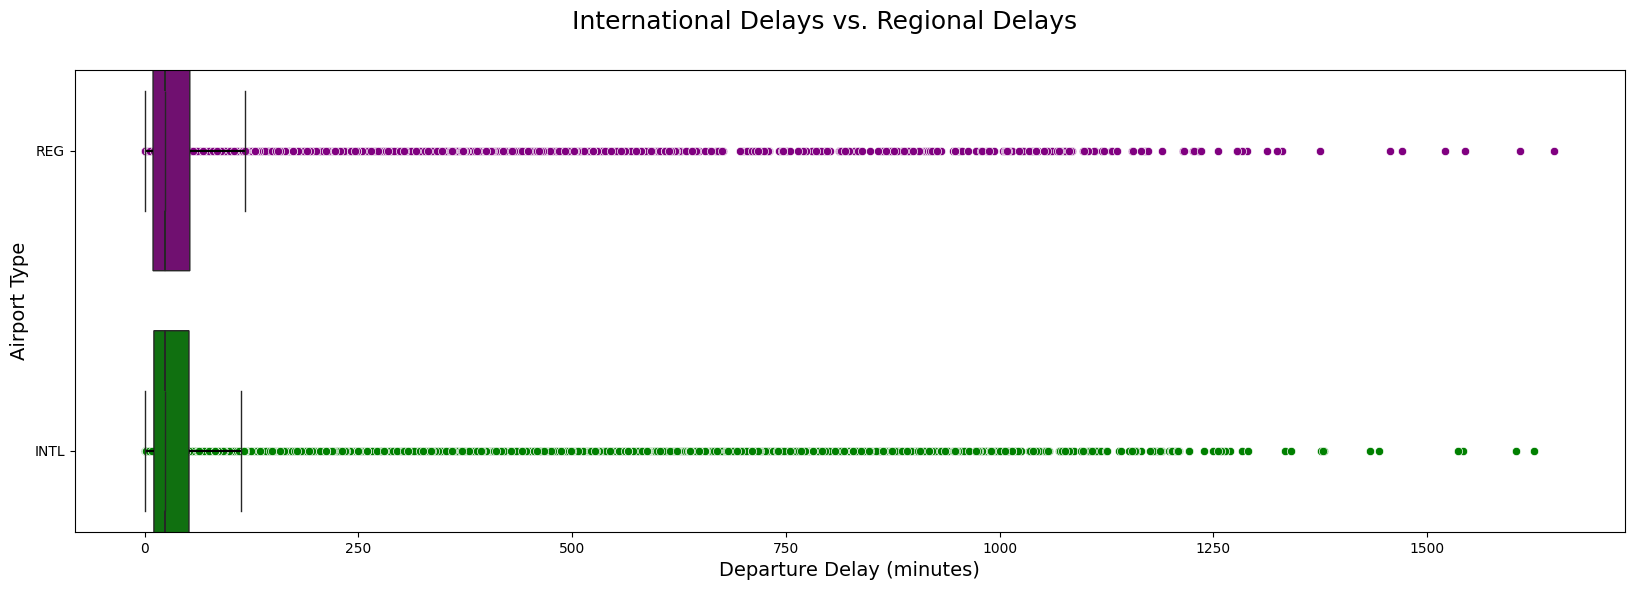

In [32]:
# Define custom colors for the boxplots
custom_palette = {'INTL': 'green', 'REG': 'purple'}

# Create the boxplot
plt.subplots(nrows=1, ncols=1, figsize=(20,6))
plt.suptitle('International Delays vs. Regional Delays', size=18)
sns.boxplot(x='DEPARTURE_DELAY', y='Status', hue='Status', data=df_all_delay, palette=custom_palette, 
            flierprops=dict(markerfacecolor='none', markeredgecolor='none', alpha=0.0),
            whiskerprops=dict(color='black', linewidth=1.5), notch=True)

# Add scatterplot with same hue colors for outlier circles
for i, status in enumerate(df_all_delay['Status'].unique()):
    sns.scatterplot(data=df_all_delay[df_all_delay['Status'] == status], x='DEPARTURE_DELAY', y='Status', color=custom_palette[status])

# Set x-label and y-label
plt.xlabel('Departure Delay (minutes)', fontsize=14)
plt.ylabel('Airport Type', fontsize=14)


# Display the boxplot
plt.show()

There is a substantial number of ourliers in the data, both for REG and INTL. Normally, investigation into these outliers would be warranted since they could cause the data to be skewed. In this case however, the outliers appear very evenly spread over both sets of data, so their inclusion in the analysis should not pose any issues. The quartiles in the boxplot are also closely aligned with each other suggesting an even distribution of data points.

In order to confirm the alternate hypothesis that Regional airports are less likely to have a delayed departure, null hypothesis tesing needs to be done so it can be rejected. Failure to reject the null hypothesis would conclude that the alternate hypothesis is incorrect.<br><br>
A/B testing will be used to compare the means from the INTL and REG flight delay data. Using Bootstrap sampling, we will sample both sets of data 10K times and plot the results in a histogram. The observed difference will also be plotted to show where the data falls in relation the sampling.

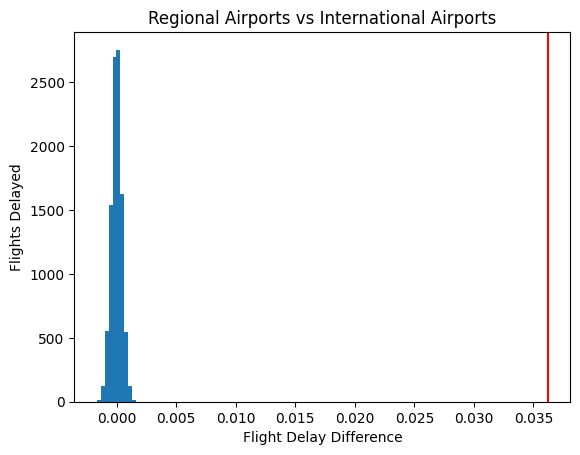

In [37]:
# Null hypotheis testing New = Old = Population
# No difference in the probability of a flight being delayed between
# Intl and Reg airports

# Get the probablility a flight being delayed for the enitre population
p_population = df_flights['DELAYED'].sum() / df_flights.shape[0]

# Probability of an INTL airport flight being delayed
p_intl = df_intl['DELAYED'].mean()  # Control

# Probability of a REG airport flight being delayed
p_reg = df_reg['DELAYED'].mean()    # Treatment

# Observed difference
obs_diff = (p_intl - p_reg)

# Set both p_new and p_old to the population probability of being delayed
p_new = pd.to_numeric(p_population)
p_old = pd.to_numeric(p_population)

# Number of flights for each airport type
n_new = df_reg['SCHEDULED_DEPARTURE'].value_counts().sum()
n_old = df_intl['SCHEDULED_DEPARTURE'].value_counts().sum()

# Simulate a sample for the REG airports - Treatment
p_val_new =[p_new, 1 - p_new]
reg_delayed = np.random.choice(2, size=n_new, p=p_val_new)

# Simulate a sample for the INTL airports - Control
p_val_old =[p_old, 1 - p_old]
intl_delayed = np.random.choice(2, size=n_old, p=p_val_old)

# Sampling distribution 
p_diffs = []

# Bootstrap samples for both new and old pages
for _ in range(10000):
    reg_delayed = np.random.choice(2, size=n_new, replace=True, p=p_val_new)
    intl_delayed = np.random.choice(2, size=n_old, replace=True, p=p_val_old)

    p_diffs.append(reg_delayed.mean() - intl_delayed.mean())

# Convert p_diffs to a numpy array so it can be ploted in a histogram
p_diffs = np.array(p_diffs)

# Create the histogram
plt.hist(p_diffs);
plt.xlabel('Flight Delay Difference')
plt.ylabel('Flights Delayed')
plt.title('Regional Airports vs International Airports')
plt.axvline(x=obs_diff, color="r")
plt.show()


In [48]:
p_val_final = (p_diffs > obs_diff).mean()
print(f'{p_val_final:10f}')

  0.000000


Based on the results from the Bootstrap sampling, it appears that there is significant statistical significance between the datasets. The P-value from the sampling is 0.00. To further confirm these results, T-Testing on independent samples of the data.

In [33]:
# Perform independent samples t-test for delayed flights
t_statistic, p_value = ttest_ind(
    df_intl[df_intl['DELAYED'] == 1]['DEPARTURE_DELAY'],
    df_reg[df_reg['DELAYED'] == 1]['DEPARTURE_DELAY'],
    equal_var=False  # Set equal_var=False if variances are assumed to be unequal
)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)


T-statistic: -13.328097501068177
P-value: 1.6333969993523695e-40


To reject the null hypothesis, a P-value less than 0.05 is desired to give us at least a 95% confidence score. The results of the T-Test delivered an extremely low P-value of 1.6333969993523695e-40, further confirming the analysis done in the Bootstrap sampling. <br><br>
One last test will be a one-way Analysis of Variance (ANOVA) test on our two datasets. This testing will compare means to see if there is any statistical significance between REG and INTL delays. 

In [34]:
from scipy.stats import f_oneway

# Perform one-way ANOVA for delayed flights
f_statistic, p_value = f_oneway(
    df_intl[df_intl['DELAYED'] == 1]['DEPARTURE_DELAY'],
    df_reg[df_reg['DELAYED'] == 1]['DEPARTURE_DELAY']
)

# Print the results
print("F-statistic:", f_statistic)
print("P-value:", p_value)


F-statistic: 215.54011158917334
P-value: 8.574463287431542e-49


The ANOVA analysis provides interesting results. The relatively large F-Statistic suggests that there is a substantial difference between the means of both groups. The P-value result is substantially below our 0.05 threshold indicating there is strong evidence to reject the null hypothesis. The combination of a high F-statistic and low P-value suggests that the differences between group means are statstically significant and not likely due to random chance.


One additional point of analysis is to see what airports have the worst delays.

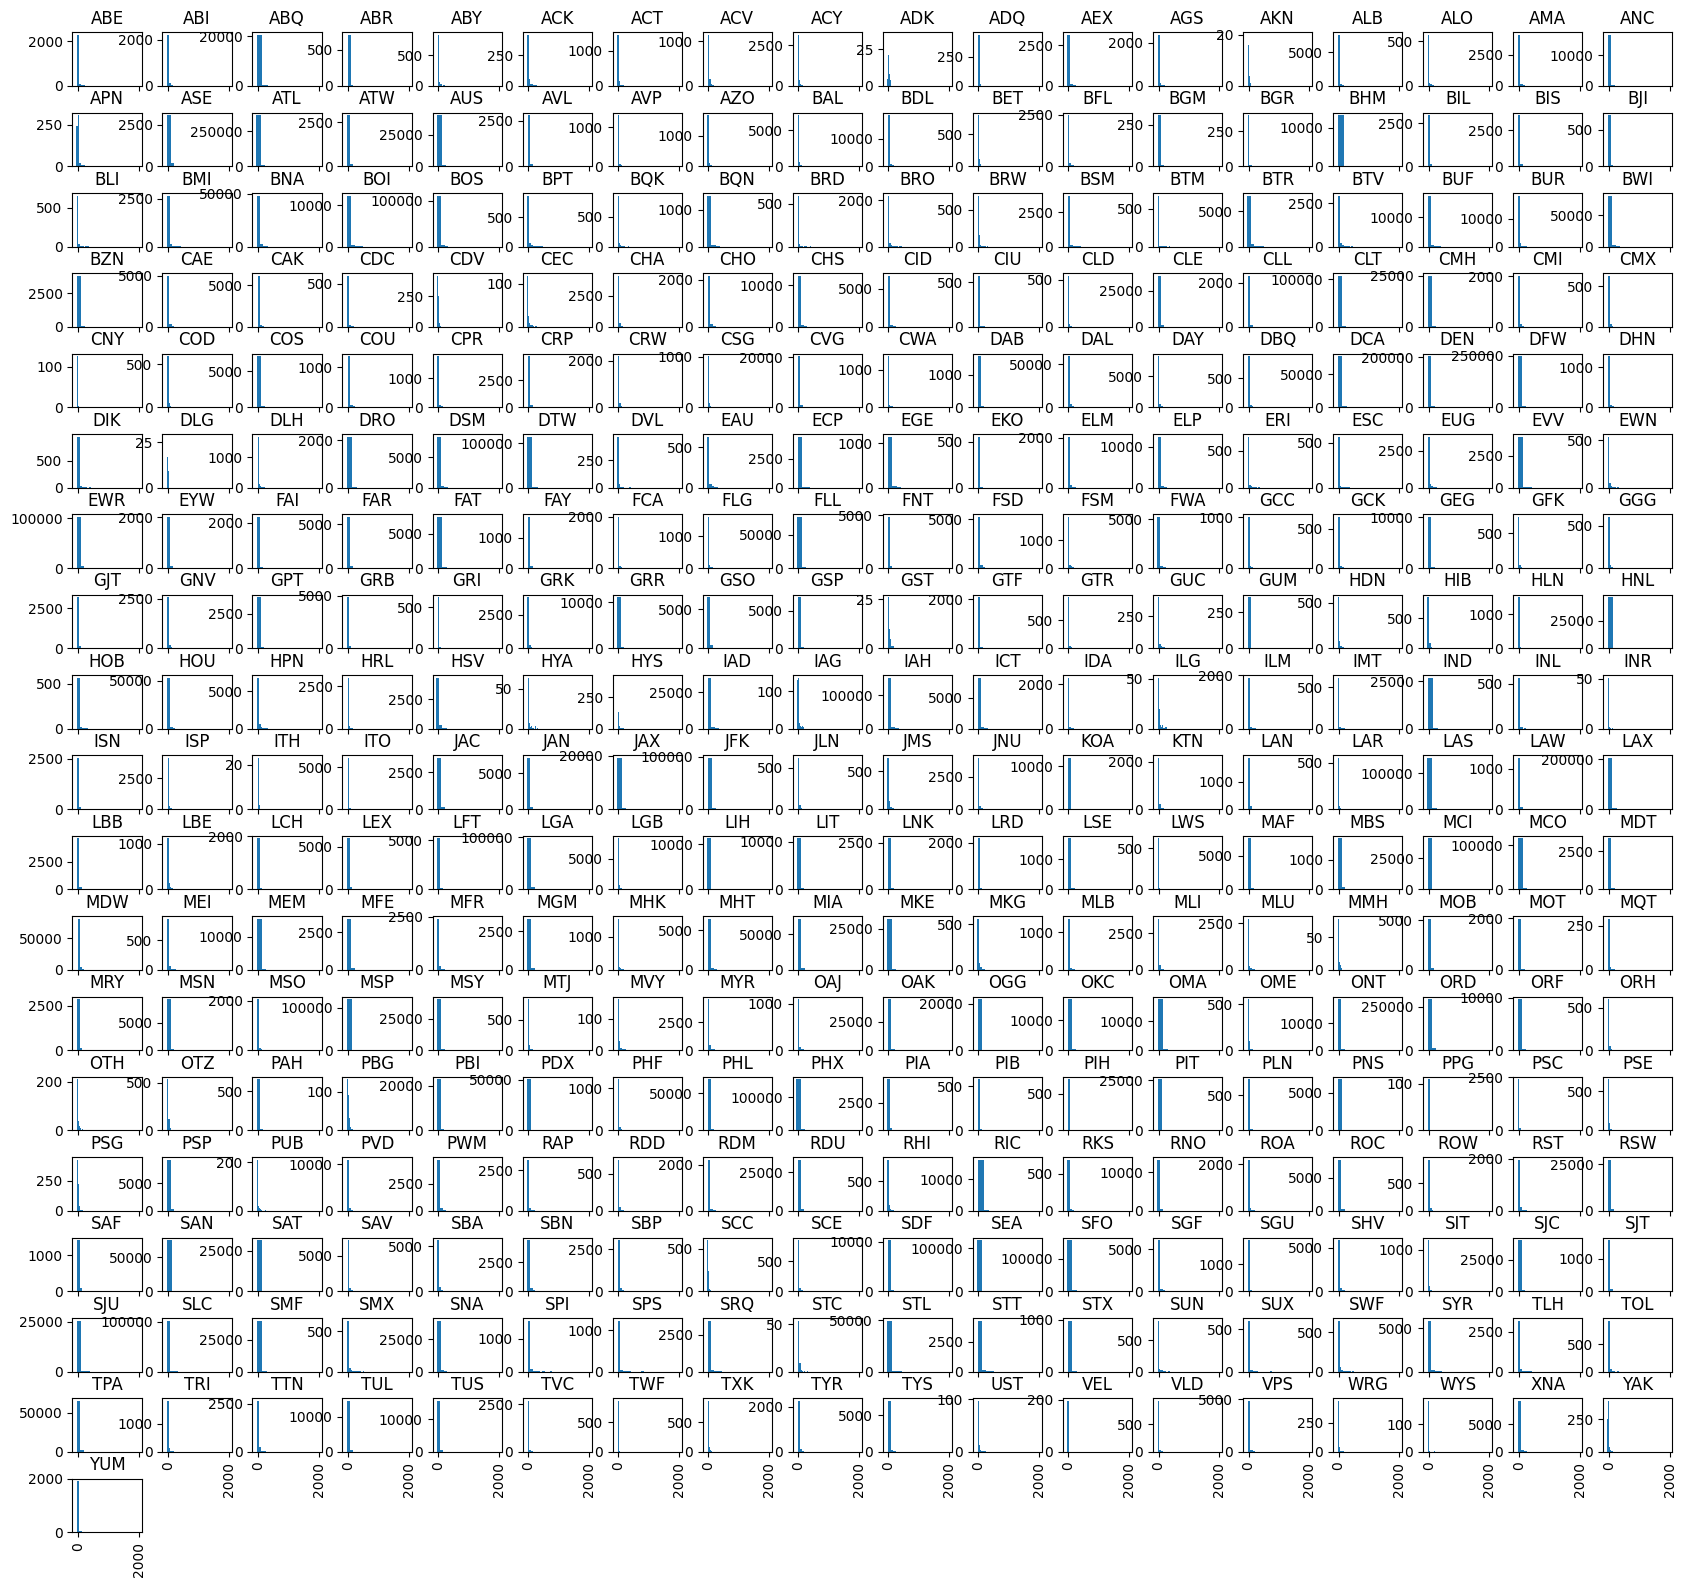

In [49]:
df_worst_airports = df_flights.groupby('DEPARTURE_DELAY').value.nlargest(10).reset_index()
df_worst_airports.hist(column='DEPARTURE_DELAY', by='ORIGIN_AIRPORT', bins=10, figsize=(20, 20), sharex=True);

## Conclusions
